<center> 
<h3><b> Adnan Rashid </b><\h3>
<br><br>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>
</center>

<h1 style="background:black">
<code style="background:black;color:white">
<center>Welcome to Kubernetes on AWS EKS</center></code></h1>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/3.jpg" width="30%" height="30%" border=5/></center>

<h1 style="background:black"><code style="background:black;color:white"><center>Contents</center></code>

* [Setup](#Setup)

* [Create EKS Cluster](./01-Create-Cluster.ipynb)
* [Deploy Official Kubernetes Dashboard](./02-Deploy-Microservices.ipynb)
* [Deploy Example MicroServices](./03-Helm.ipynb)
* [Helmv3](./04-Health-Checks.ipynb)
* [Health Checks](./05-AutoScaling)
* [Implement AutoScaling with HPA and CA](./05-AutoScaling.ipynb)
* [Intro To RBAC](./06-RBAC.ipynb)
* [Using IAM Groups to Manage Kubernetes Cluster Access](./07-IAM.ipynb)
* [IAM Roles for Service Accounts](./07-IAM.ipynb)
* [Securing Your Cluster With Network Policies](./08-Network.ipynb)
* [Exposing a Service](./09-Service.ipynb)
* [Assigning Pods to Nodes](./10-Pods-Nodes.ipynb)
* [Using Spot Instances with EKS](./10-Pods-Nodes.ipynb)
* [Advanced VPC Networking with EKS](./11-VPC.ipynb)
* [Stateful Containers using StatefulSets](./12-State.ipynb)
* [Deploying Microservices to EKS Fargate](./13-Fargate.ipynb)
* [Deploying Microservices with AWS EFS](./14-EFS.ipynb)
* [Encrypting Kubernetes Secrets](./15-Secrets.ipynb)
* [Final Cleanup](./99-Final-CleanUp.ipynb)

<br><br>

<h1 style="background:black"><code style="background:black;color:white"><center>Setup</center></code>

## Prerequisties

* You must have a basic understanding of AWS concepts to complete this entire playbook. 

* You can use either a ubuntu environment which has everything preinstalled and configured OR configure yourself **manually**

* Launch Jupyter Lab rather than Jupyter Notebook as it will provide a better experience 

* Use Dark theme by going to Settings --> JupyterLab Theme --> JupyterLab Dark

## <br><br>Important Information 

* The temp folder is ignored by .gitignore 

## <br><br>Tooling

The following tools are needed to carry out the tasks

#### Introduction to JupyterLab

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('A5YyoCKxEOU&t=67s')

#### Install Kubernetes Tools (Essential)

<br>The Kubernetes command-line tool, kubectl, allows you to run commands against Kubernetes clusters. You can use kubectl to deploy applications, inspect and manage cluster resources, and view logs.

In [2]:
from IPython.display import IFrame
IFrame('https://kubernetes.io/docs/tasks/tools/install-kubectl/',
       width='100%', height=500)

#### <br><Br>Install AWS CLI (Essential)

The AWS Command Line Interface (CLI) is a unified tool to manage your AWS services

#### <br><br>Install EKSCTL (Essential)

eksctl is a simple CLI tool for creating clusters on EKS - Amazon's new managed Kubernetes service for EC2. It is written in Go, uses CloudFormation and was created by Weaveworks.

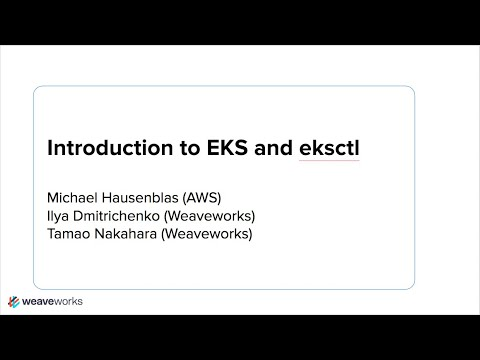

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('sryU3SkBjm8')

#### <br><br>Install Lens IDE (Recommended) 

As you go through this course, there may be times when something is not working as expected in Kubernetes. This IDE gives you a nice simple way to see inside the cluster including any errors rather than doing everything on the command line

In [4]:
from IPython.display import IFrame
IFrame('https://k8slens.dev/', width='100%', height=500)

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/epw_MjxjMYI?controls=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

#### <br><br>Block secrets from being committed to Github (Recommended)

This will ensure you are not commiting anything sensitive to github such as access keys or even AWS account numbers 

## <br><br>AWS Setup

* Set the profile you would like to use, the region you would like EKS to launch into and AWS account number
* It is recommended to do eu-west-1 as this supports all features.

In [ ]:
AWS_PROFILE=''
AWS_DEFAULT_REGION='eu-west-1'
ACCOUNT_ID=

* Store for future usage and set for this notebook usage

In [ ]:
%store AWS_PROFILE
%store AWS_DEFAULT_REGION
%store ACCOUNT_ID

%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

#### <br><br>Create an SSH Key

* Generate a keypair called 'eksworkshop' 

In [ ]:
!aws ec2 create-key-pair --key-name eksworkshop > temp/eksworkshop.pem

#### <br><br>KMS CMK Key

These are the encryption keys we will use to encrypt our data 

In [ ]:
!aws kms create-alias --alias-name alias/eksworkshop --target-key-id $(aws kms create-key --query KeyMetadata.Arn --output text)

* Get master arn value of the KMS key

In [ ]:
!aws kms describe-key --key-id alias/eksworkshop --query KeyMetadata.Arn --output text

* Save the value in a variable

In [ ]:
MASTER_ARN=''
%store MASTER_ARN

<br><br>This is needed to integrate EKS with KMS and can only be done at creation time. We will also create secrets later on which will make use of the KMS integration with CloudTrail 

<br><br>
<div class="alert alert-block alert-info">
<font style="color:black">
<center>
As we will be moving variables across notebooks, we need to keep some persistence. We will use the %store magic to do this.<br><br> In each notebook at the start, we run %store -r to recall the variables 

### <br><br><center> We are ready to create the EKS cluster now! :) 